# Model Training for Charpy Temperature Prediction

## Objective

Train and evaluate regression models to predict Charpy Temperature (°C) from PCA-transformed features.

**About Charpy Temperature**: The testing temperature is crucial for assessing material behavior in different service conditions. Lower temperatures generally result in reduced toughness, making this parameter critical for cold-climate applications.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/welddb_pca_charpy_temp.csv')
print(f"Data shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Data shape: (879, 15)

First few rows:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,Charpy_Temp_C
0,-1.111984,-0.263949,-1.704774,0.393621,0.785069,-0.283643,0.226367,0.411903,0.032662,-1.337822,-1.667102,0.366984,0.316383,0.135545,0.190282
1,-0.416959,-0.867663,-1.822341,0.613313,1.205411,-0.281104,-0.192307,0.296526,0.377337,-0.957682,-1.022218,1.015546,0.631689,0.212360,-0.097746
2,-1.283343,-0.025882,-1.626590,0.429106,0.481750,-0.115155,0.148931,0.648261,-0.375164,-1.112571,-1.015294,0.531599,0.405035,0.250926,-0.385774
3,-0.588318,-0.629596,-1.744157,0.648799,0.902091,-0.112616,-0.269743,0.532884,-0.030489,-0.732431,-0.370411,1.180161,0.720342,0.327741,-0.270563
4,-1.520966,0.236829,-1.476447,0.463252,0.089410,0.091533,-0.088714,0.882214,-0.658019,-0.724643,-0.286923,0.606931,0.452478,0.274635,-0.529788


In [3]:
X = df.drop('Charpy_Temp_C', axis=1)
y = df['Charpy_Temp_C']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")
print(f"\nCharpy Temperature statistics:")
print(f"  Mean: {y.mean():.2f}°C")
print(f"  Std: {y.std():.2f}°C")
print(f"  Range: [{y.min():.2f}°C, {y.max():.2f}°C]")

Features: (879, 14)
Target: (879,)

Charpy Temperature statistics:
  Mean: 0.00°C
  Std: 1.00°C
  Range: [-2.29°C, 6.41°C]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 703 samples
Testing set: 176 samples


## Model Configuration

Using 8 regression models with simplified hyperparameter grids for efficient training:
- **Linear Models**: LinearRegression, Ridge, Lasso, ElasticNet
- **Tree Models**: DecisionTree, RandomForest, GradientBoosting
- **Kernel Model**: SVR

In [5]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'Lasso': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'ElasticNet': {
        'alpha': [0.1, 1.0],
        'l1_ratio': [0.3, 0.5, 0.7]
    },
    'DecisionTree': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5]
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    },
    'SVR': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['rbf', 'linear'],
        'epsilon': [0.1, 0.2]
    }
}

print(f"Models configured: {len(models)}")
for name, params in param_grids.items():
    n_combinations = np.prod([len(v) for v in params.values()]) if params else 1
    print(f"  - {name}: {n_combinations} hyperparameter combinations")

Models configured: 8
  - LinearRegression: 1 hyperparameter combinations
  - Ridge: 3 hyperparameter combinations
  - Lasso: 3 hyperparameter combinations
  - ElasticNet: 6 hyperparameter combinations
  - DecisionTree: 8 hyperparameter combinations
  - RandomForest: 12 hyperparameter combinations
  - GradientBoosting: 12 hyperparameter combinations
  - SVR: 12 hyperparameter combinations


## Training with GridSearchCV

In [6]:
results = []
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    if param_grids[name]:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', 
                           n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"\nBest parameters: {grid.best_params_}")
        print(f"Best CV R²: {grid.best_score_:.4f}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
        print(f"\nCV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results.append({
        'Model': name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Overfit_Score': train_r2 - test_r2
    })
    
    trained_models[name] = best_model
    
    print(f"\n📊 Results:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.2f}°C")
    print(f"  Test RMSE:  {test_rmse:.2f}°C")
    print(f"  Test MAE:   {test_mae:.2f}°C")
    print(f"  Overfit:    {train_r2 - test_r2:.4f}")

print(f"\n\n{'='*60}")
print("✅ Training Complete!")
print(f"{'='*60}")


Training LinearRegression...

CV R²: 0.2529 ± 0.0547

📊 Results:
  Train R²: 0.3121
  Test R²:  0.1526
  Train RMSE: 0.85°C
  Test RMSE:  0.84°C
  Test MAE:   0.66°C
  Overfit:    0.1595

Training Ridge...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best parameters: {'alpha': 10.0}
Best CV R²: 0.2542

📊 Results:
  Train R²: 0.3121
  Test R²:  0.1542
  Train RMSE: 0.85°C
  Test RMSE:  0.84°C
  Test MAE:   0.66°C
  Overfit:    0.1579

Training Lasso...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best parameters: {'alpha': 0.1}
Best CV R²: 0.1993

📊 Results:
  Train R²: 0.2335
  Test R²:  0.1069
  Train RMSE: 0.89°C
  Test RMSE:  0.86°C
  Test MAE:   0.70°C
  Overfit:    0.1266

Training ElasticNet...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters: {'alpha': 10.0}
Best CV R²: 0.2542

📊 Results:
  Train R²: 0.3121
  Test R²:  0.1542
  Train RMSE: 0.85°C
  Test RMSE: 

## Results Summary

In [7]:
results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False)
print("\n📊 Model Performance Comparison:")
print(results_df.to_string(index=False))

results_df.to_csv('trained_models/model_comparison.csv', index=False)
print("\n✅ Results saved to: trained_models/model_comparison.csv")


📊 Model Performance Comparison:
           Model  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Overfit_Score
             SVR  0.457120 0.298911    0.751759   0.763125   0.536571  0.589885       0.158209
GradientBoosting  0.415049 0.233102    0.780345   0.798138   0.599681  0.647573       0.181947
    RandomForest  0.564061 0.178211    0.673658   0.826209   0.473174  0.660645       0.385851
           Ridge  0.312061 0.154199    0.846256   0.838192   0.654474  0.663093       0.157862
LinearRegression  0.312130 0.152628    0.846213   0.838970   0.654547  0.663238       0.159502
      ElasticNet  0.295795 0.147472    0.856202   0.841518   0.660816  0.678006       0.148323
    DecisionTree  0.419406 0.126950    0.777433   0.851587   0.589248  0.669162       0.292457
           Lasso  0.233485 0.106887    0.893279   0.861316   0.688955  0.701361       0.126598

✅ Results saved to: trained_models/model_comparison.csv


In [8]:
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_r2 = results_df.iloc[0]['Test_R2']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R²: {best_r2:.4f}")
print(f"   Test RMSE: {results_df.iloc[0]['Test_RMSE']:.2f}°C")
print(f"   Test MAE: {results_df.iloc[0]['Test_MAE']:.2f}°C")

joblib.dump(best_model, f'trained_models/best_model_{best_model_name}.pkl')
print(f"\n✅ Best model saved to: trained_models/best_model_{best_model_name}.pkl")


🏆 Best Model: SVR
   Test R²: 0.2989
   Test RMSE: 0.76°C
   Test MAE: 0.59°C

✅ Best model saved to: trained_models/best_model_SVR.pkl


## Visualization 1: Model Performance Comparison

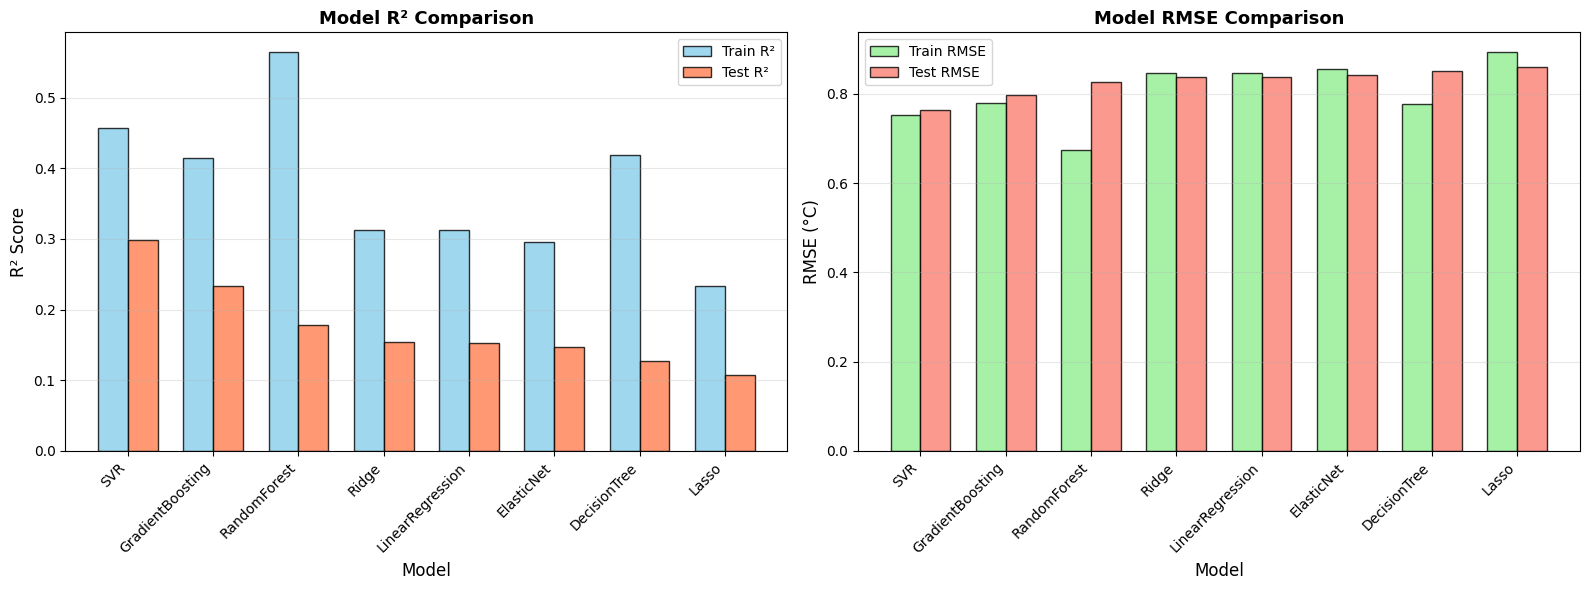

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² comparison
x = np.arange(len(results_df))
width = 0.35

axes[0].bar(x - width/2, results_df['Train_R2'], width, label='Train R²', 
           alpha=0.8, color='skyblue', edgecolor='black')
axes[0].bar(x + width/2, results_df['Test_R2'], width, label='Test R²', 
           alpha=0.8, color='coral', edgecolor='black')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model R² Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# RMSE comparison
axes[1].bar(x - width/2, results_df['Train_RMSE'], width, label='Train RMSE', 
           alpha=0.8, color='lightgreen', edgecolor='black')
axes[1].bar(x + width/2, results_df['Test_RMSE'], width, label='Test RMSE', 
           alpha=0.8, color='salmon', edgecolor='black')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('RMSE (°C)', fontsize=12)
axes[1].set_title('Model RMSE Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 2: Best Model Predictions

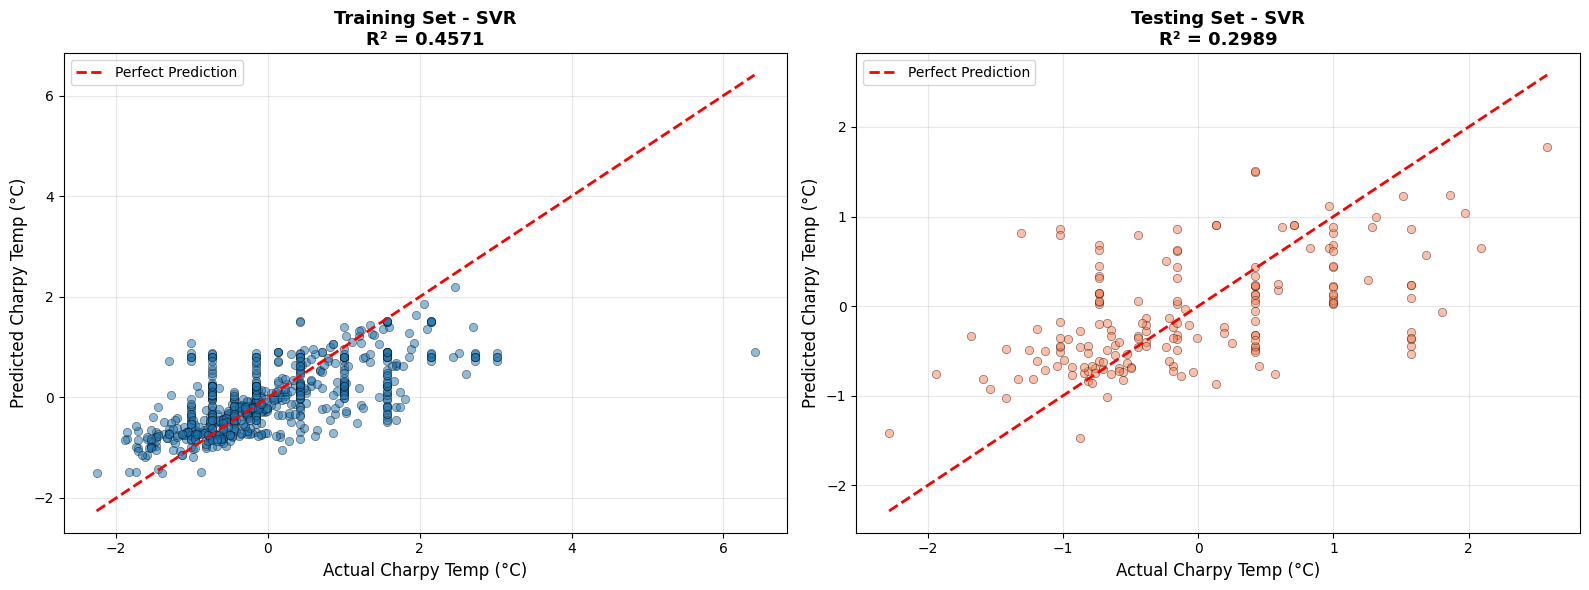

In [10]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training predictions
axes[0].scatter(y_train, y_train_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Charpy Temp (°C)', fontsize=12)
axes[0].set_ylabel('Predicted Charpy Temp (°C)', fontsize=12)
axes[0].set_title(f'Training Set - {best_model_name}\nR² = {results_df.iloc[0]["Train_R2"]:.4f}', 
                 fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Testing predictions
axes[1].scatter(y_test, y_test_pred, alpha=0.5, color='coral', edgecolors='k', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Charpy Temp (°C)', fontsize=12)
axes[1].set_ylabel('Predicted Charpy Temp (°C)', fontsize=12)
axes[1].set_title(f'Testing Set - {best_model_name}\nR² = {results_df.iloc[0]["Test_R2"]:.4f}', 
                 fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 3: Residual Analysis

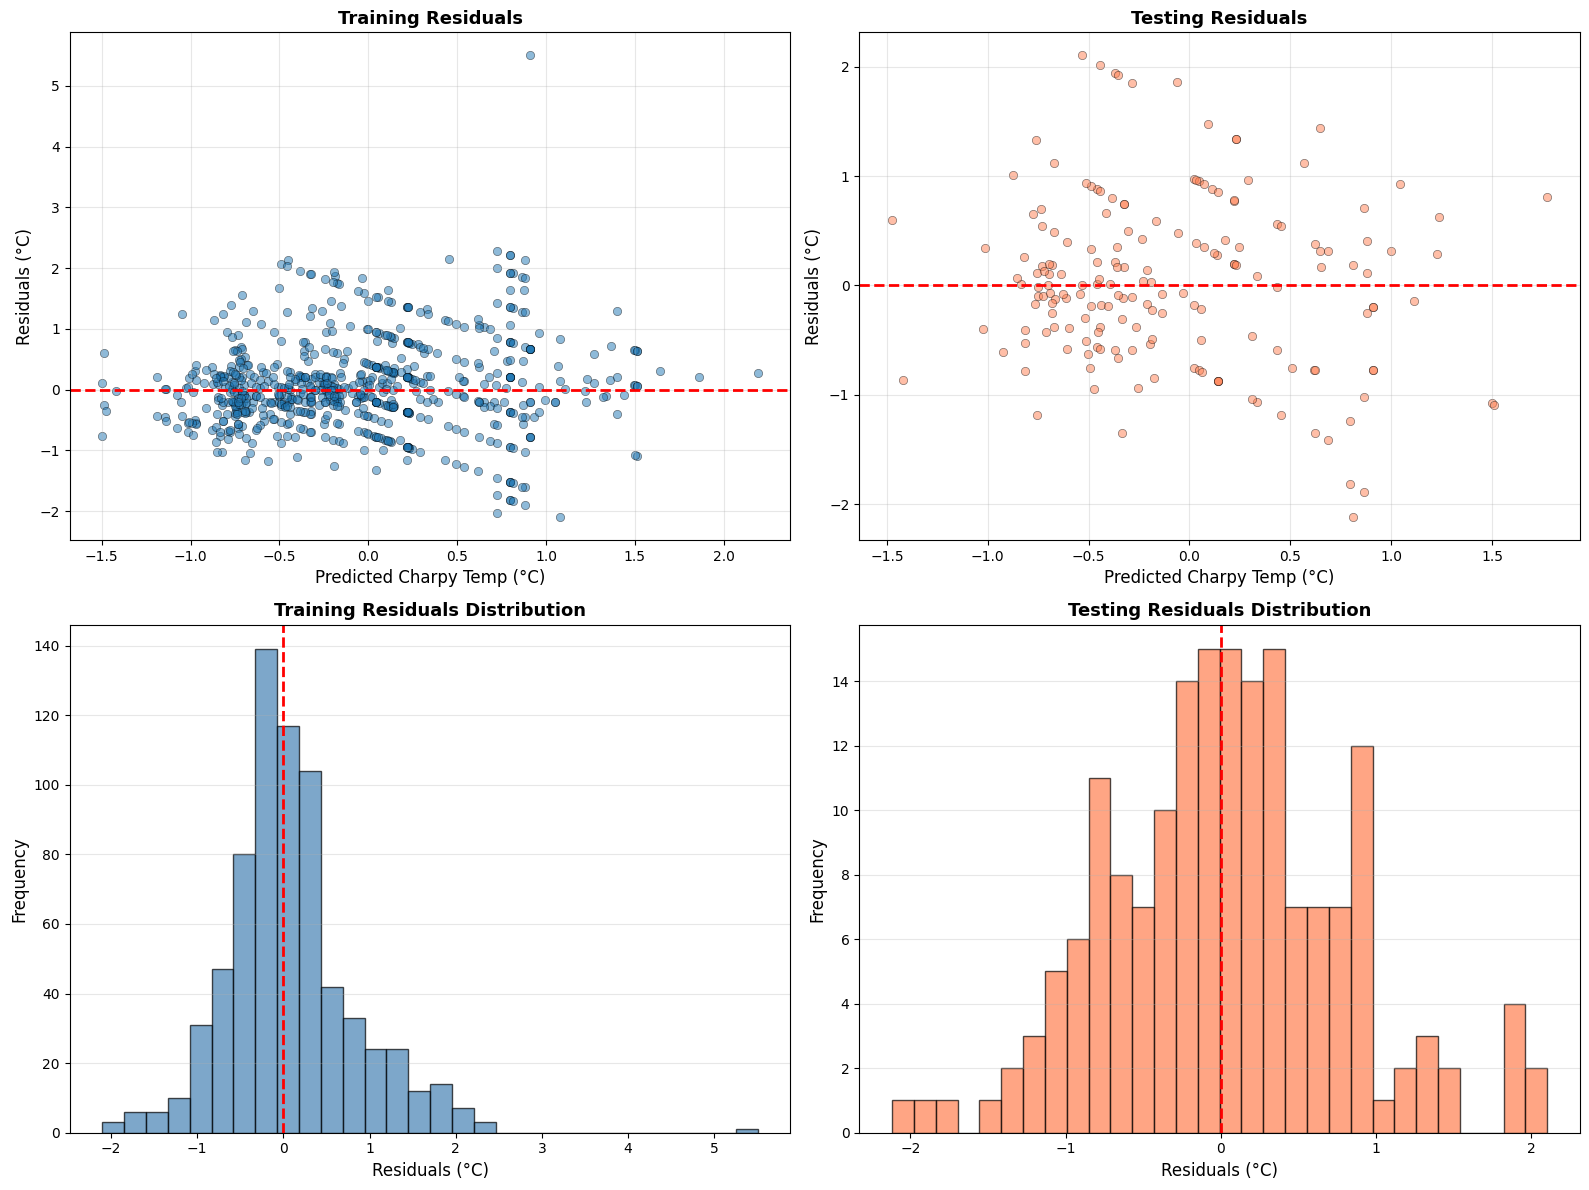


📊 Residual Statistics:
  Training: Mean = 0.075°C, Std = 0.749°C
  Testing:  Mean = 0.032°C, Std = 0.765°C


In [11]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training residuals vs predicted
axes[0, 0].scatter(y_train_pred, train_residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Charpy Temp (°C)', fontsize=12)
axes[0, 0].set_ylabel('Residuals (°C)', fontsize=12)
axes[0, 0].set_title('Training Residuals', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Testing residuals vs predicted
axes[0, 1].scatter(y_test_pred, test_residuals, alpha=0.5, color='coral', edgecolors='k', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Charpy Temp (°C)', fontsize=12)
axes[0, 1].set_ylabel('Residuals (°C)', fontsize=12)
axes[0, 1].set_title('Testing Residuals', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Training residuals histogram
axes[1, 0].hist(train_residuals, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals (°C)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Training Residuals Distribution', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Testing residuals histogram
axes[1, 1].hist(test_residuals, bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals (°C)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Testing Residuals Distribution', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Residual Statistics:")
print(f"  Training: Mean = {train_residuals.mean():.3f}°C, Std = {train_residuals.std():.3f}°C")
print(f"  Testing:  Mean = {test_residuals.mean():.3f}°C, Std = {test_residuals.std():.3f}°C")